In [1]:
suppressMessages ( library ( dplyr ) )
library(ggplot2)

**1.** Considere os dados a seguir de um Estudo de Bioequivalência de um Medicamento Novo relativamente a um Medicamento Padrão no tratamento de uma doença. Respostas de pacientes a um Placebo também são apresentadas.
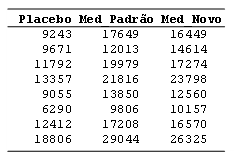
Neste tipo de estudo, órgãos reguladores adotam o seguinte critério para comprovação da bioequivalência do medicamento novo:
<center> $ANVISA: \theta=\frac{|\mu_{NOVO}-\mu_{ANTIGO}|}{\mu_{ANTIGO}-\mu_{PLACEBO}}\le 0,2$
    
Construa um intervalo bootstrap de 95% de confiança para o parâmetro $\theta$. Que conclusão é obtida? Na solução, considere:

a) Delineamento completamente aleatorizado (DCA) em que os três tratamentos foram atribuídos aleatoriamente a 8 pacientes de uma amostra de 32 voluntários, que aceitaram participar do estudo e cumpriram a todos os critérios de inclusão.

In [2]:
# Construindo dataframe
valores = c ( 
#     Placebo
    9243 , 9671 , 11792 , 13357 ,9055 , 6290 , 12412 , 18806 , 
#     Med Padrao
    17649 , 12013 , 19979 , 21816 , 13850 , 9806 , 17208 , 29044 ,
#     Med Novo
    16449 , 14614 , 17274 , 23798 , 12560 , 10157 , 16570 , 26325
            )

df1 = valores %>% as.data.frame ( )
colnames ( df1 ) = "Valores"
df1 = df1 %>% mutate ( trat = c ( rep ( "Placebo" , 8 ) , rep ( "MedPadrao" , 8 ) , rep ( "MedNovo" , 8 ) ) )
df1 %>% head ( 12 )

,Valores,trat
,<dbl>,<chr>
1,9243,Placebo
2,9671,Placebo
3,11792,Placebo
4,13357,Placebo
5,9055,Placebo
6,6290,Placebo
7,12412,Placebo
8,18806,Placebo
9,17649,MedPadrao


#### Calculo do valor theta


In [3]:
medias1 = tapply ( df1$Valores , df1$trat , "mean" )
theta = abs ( medias1[["MedNovo"]] - medias1[["MedPadrao"]] ) / (medias1[["MedPadrao"]] - medias1[["Placebo"]])
print( theta )

[1] 0.0713061


In [4]:
# 24 pacientes para 3 tratamentos, em DCA - aleatorizar medicamentos às respostas
# Dado que eh conhecido que o remedio tem efeito, aleatorizar primeiro apenas dentro de placebo e apenas entre os tratamentos,
# de forma separada
numeroSimulacoes = 1e3
thetasBoot = numeric( numeroSimulacoes )
i = 1
set.seed ( 9297791 )
while ( i < numeroSimulacoes ){
        
    mediaNovaBoot = mean ( df1[sample( rownames ( df1[df1$trat=='MedNovo' , ] ) , replace = T ) , "Valores" ] )
    mediaPadraoBoot = mean ( df1[sample( rownames ( df1[df1$trat=='MedPadrao' , ] ) , replace = T ) , "Valores" ] )
    mediaPlaceboBoot = mean ( df1[sample( rownames ( df1[df1$trat=='Placebo' , ] ) , replace = T ) , "Valores" ] )
    
    thetasBoot[i] = abs ( mediaNovaBoot - mediaPadraoBoot ) / (mediaPadraoBoot - mediaPlaceboBoot)
    i = i + 1
        
}

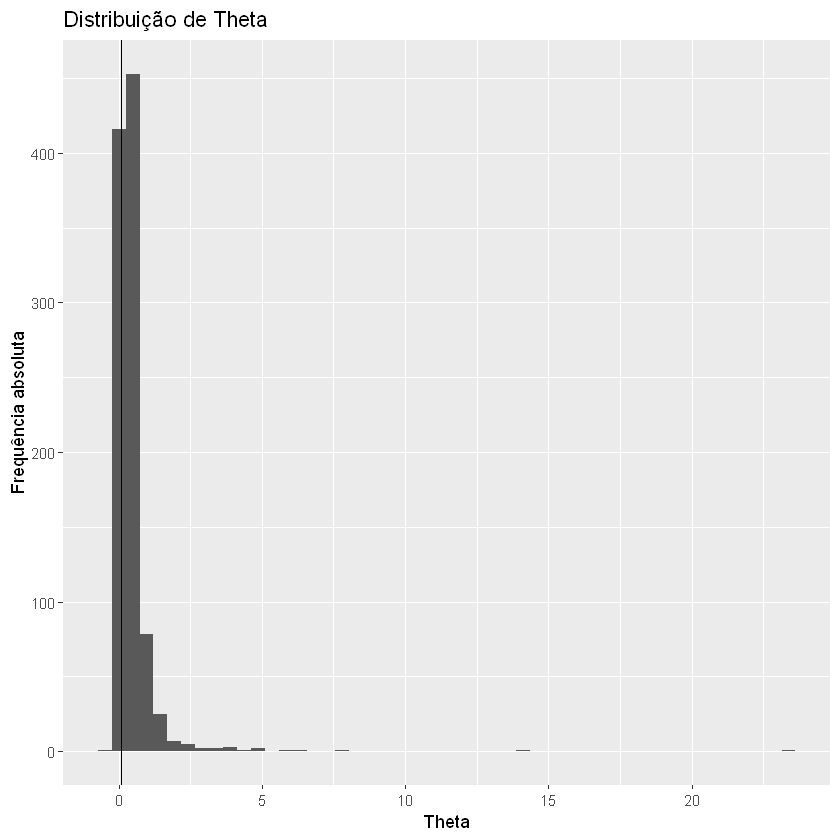

In [5]:
thetasBoot1a = thetasBoot %>% as.data.frame ( )
colnames ( thetasBoot1a ) = "Theta"

plotDistrib = thetasBoot1a %>% ggplot ( aes ( x = Theta ) ) + 
geom_histogram ( bins = 50 ) +  
# xlim(-10, 10) + 
geom_vline ( xintercept = theta ) +
labs ( x = "Theta" , y = "Frequência absoluta" , title = "Distribuição de Theta" )

plotDistrib

In [6]:
quantis = quantile(thetasBoot , c ( .025 , .975 ))
print ( paste0 ( "Limite de confiança Effron: " , "[" , round ( quantis[[1]] , 2 ) , ";" , round ( quantis[[2]] , 2 ) , "]"  ) )

[1] "Limite de confiança Effron: [0.01;1.85]"


**Conclusão:** Pelo limite de confiança de Efron, concluímos que não há evidências de bioequivalência entre os medicamentos (intervalo de confiança abrangente demais).

b) Delineamento Aleatorizado em Blocos Completos em que os três tratamentos foram aplicados a 8 pacientes voluntários, que aceitaram participar do estudo e cumpriram a todos os critérios de inclusão. Para cada paciente a ordem do tratamento foi aleatorizada, sendo que entre os tratamentos foi respeitado um período de “limpeza” (washout) do organismo. 

In [7]:
# Considerando agora que cada indivíduo é um bloco, temos que as observacoes estao atreladas a cada linha.
# Isto eh, a amostragem deve ocorrer no indice das linhas
# 24 pacientes para 3 tratamentos, em DCA - aleatorizar tratamentos às respostas

df1b = df1 %>% mutate ( idLinha = rep ( 1:8 , 3 ) )
df1b %>% head ( 10 )

,Valores,trat,idLinha
,<dbl>,<chr>,<int>
1,9243,Placebo,1
2,9671,Placebo,2
3,11792,Placebo,3
4,13357,Placebo,4
5,9055,Placebo,5
6,6290,Placebo,6
7,12412,Placebo,7
8,18806,Placebo,8
9,17649,MedPadrao,1


In [8]:
thetasBoot2 = numeric( numeroSimulacoes )
i = 1
set.seed ( 9297791 )
while ( i < numeroSimulacoes ){
    
    idLinha = sample ( 1:8 , replace = T )
    ids = idLinha %>% as.data.frame ( )
    colnames ( ids ) = "idLinha"
    dfBoot = merge ( df1b , ids , by = 'idLinha' )
    mediasBoot = tapply ( dfBoot$Valores , dfBoot$trat , "mean" )
    mediaNovaBoot = mediasBoot[["MedNovo"]]
    mediaPadraoBoot = mediasBoot[["MedPadrao"]]
    mediaPlaceboBoot = mediasBoot[["Placebo"]]
    
    if ( mediaPadraoBoot != mediaPlaceboBoot ){
        
        thetasBoot2[i] = abs ( mediaNovaBoot - mediaPadraoBoot ) / (mediaPadraoBoot - mediaPlaceboBoot)
        i = i + 1
        
    }
    
    
}

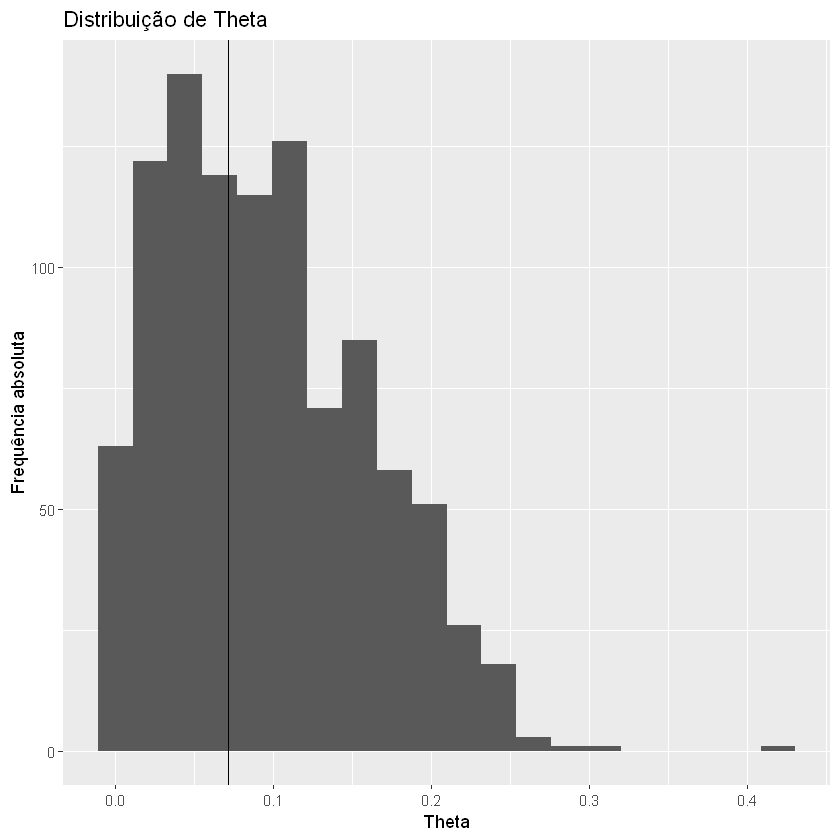

In [9]:
thetasBoot1b = thetasBoot2 %>% as.data.frame ( )
colnames ( thetasBoot1b ) = "Theta"

plotDistrib = thetasBoot1b %>% ggplot ( aes ( x = Theta ) ) + 
geom_histogram ( bins = 20 ) +  
# xlim(-10, 10) + 
geom_vline ( xintercept = theta ) +
labs ( x = "Theta" , y = "Frequência absoluta" , title = "Distribuição de Theta" )

plotDistrib

In [10]:
quantis = quantile(thetasBoot2 , c ( .025 , .975 ))
print ( paste0 ( "Limite de confiança Effron: " , "[" , round ( quantis[[1]] , 2 ) , ";" , round ( quantis[[2]] , 2 ) , "]"  ) )

[1] "Limite de confiança Effron: [0.01;0.23]"


**Conclusão:** Pelo limite de confiança, ainda conclui-se que não há bioequivalência entre os medicamentos (pois existem $\theta$'s maiores do que o limite estipulado pela ANVISA).

2. Considere os dados a seguir apresentados em Manly (2007), que correspondem à distribuição (em porcentagem) de indivíduos de 17 colônias de caracol de acordo com o tipo de concha. As colônias estão classificadas de acordo com o tipo de habitat dos caracóis.
Como trata-se de dados composicionais (cada linha soma 100%), na realização das análises a seguir exclua a última coluna de dados.


In [11]:
dados2 = read.table('~/Monitoria/Dados/lista4Ex2.csv' , sep = ';' , header = T , dec = ',' )
dados2 %>% head(5)

,Habitat,Colony,YellowUB,YellowMB,YellowFB,YellowOB,PinkUB,PinkMB,PinkFB,PinkOB,BrownUB,BrownB
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Downland beech,1,9.6,15.4,0.0,0.0,48.7,25.0,0.0,0.0,0.6,0.6
2,Downland beech,2,10.6,16.0,0.0,0.0,26.3,4.5,0.0,0.0,36.5,5.8
3,Oakwood,1,1.2,4.7,1.2,1.2,5.8,25.6,4.7,1.2,34.9,19.8
4,Oakwood,2,0.0,13.0,0.5,0.0,27.6,43.2,3.8,8.6,0.0,3.2
5,Oakwood,3,1.5,1.0,0.7,0.5,23.2,28.4,10.7,23.8,10.2,0.0


In [12]:
# Excluindo ultima coluna
dados2 = dados2[,-12]
dadosPad = dados2
dadosPad[ , 3 : 11 ] = scale ( dadosPad[ , 3 : 11 ] )
dadosPad %>% head(5)

,Habitat,Colony,YellowUB,YellowMB,YellowFB,YellowOB,PinkUB,PinkMB,PinkFB,PinkOB,BrownUB
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Downland beech,1,0.4528595,1.4958322,-0.8573030,-0.9711100,2.1254980,1.1322933,-1.1167962,-1.3297705,-0.82932478
2,Downland beech,2,0.5796900,1.6002640,-0.8573030,-0.9711100,0.6829928,-0.5490199,-1.1167962,-1.3297705,1.98410997
3,Oakwood,1,-0.6125167,-0.3665352,-0.7729375,-0.8037904,-0.6371569,1.1815025,-0.7729349,-1.1915069,1.85872012
4,Oakwood,2,-0.7647133,1.0781050,-0.8221507,-0.9711100,0.7667097,2.6249714,-0.8387807,-0.3388814,-0.87634597
5,Oakwood,3,-0.5744675,-1.0105314,-0.8080898,-0.9013935,0.4833604,1.4111453,-0.3339630,1.4124576,-0.07698568


a) Em Análise de Componentes Principais (CP), por exemplo, da matriz Y17x9  dos dados dos caracóis, há interesse em avaliar quantos componentes devem ser retidos na redução de dimensionalidade dos dados. Um dos critérios é adotar os primeiros CP extraídos dos dados originais com variância (autovalor) maior ou igual à média dos autovalores. No caso de dados padronizados esse critério corresponde a considerar os CP com autovalores maiores ou iguais a 1. Para os dados dos caracóis obtenha os CP e os correspondentes intervalos bootstrap a 95% de confiança para os autovalores.

In [13]:
# Calculo dos CP (excluindo info de colonias)
matrizCov = cov ( dadosPad [ , -1:-2 ] )
matrizCov

,YellowUB,YellowMB,YellowFB,YellowOB,PinkUB,PinkMB,PinkFB,PinkOB,BrownUB
YellowUB,1.00000000,0.291002692,-0.168452909,0.0286129,-0.081378156,-0.27519052,-0.3555966,-0.26317815,0.281424793
YellowMB,0.29100269,1.000000000,-0.005200163,-0.2060514,0.112702772,0.23993665,-0.5496313,-0.64354868,0.050359795
YellowFB,-0.16845291,-0.005200163,1.000000000,0.5030096,-0.535076435,-0.46776419,0.2465008,0.03765918,-0.440155177
YellowOB,0.02861290,-0.206051428,0.503009565,1.0000000,-0.424984934,-0.54421028,0.1947720,0.32152413,-0.327542594
PinkUB,-0.08137816,0.112702772,-0.535076435,-0.4249849,1.000000000,0.37372463,-0.3775150,-0.33136459,0.006850406
PinkMB,-0.27519052,0.239936646,-0.467764193,-0.5442103,0.373724626,1.00000000,-0.4146065,-0.18826068,-0.042317283
PinkFB,-0.35559660,-0.549631303,0.246500768,0.1947720,-0.377515025,-0.41460653,1.0000000,0.70549460,-0.438828962
PinkOB,-0.26317815,-0.643548682,0.037659178,0.3215241,-0.331364590,-0.18826068,0.7054946,1.00000000,-0.403396517
BrownUB,0.28142479,0.050359795,-0.440155177,-0.3275426,0.006850406,-0.04231728,-0.4388290,-0.40339652,1.000000000


In [14]:
decomp = eigen ( matrizCov )
autoValMaioresMedia = which(decomp$values >= mean ( decomp$values ) )
print ( paste0 ( "Os " , length ( autoValMaioresMedia ) , 
                " primeiros componentes principais representam " , 
                100*round ( sum ( decomp$values[ autoValMaioresMedia ] ) /sum( decomp$values ) , 4 ),
               "% da variância total"
               ) )

[1] "Os 3 primeiros componentes principais representam 72.57% da variância total"


In [15]:
# Limites de confianca
numeroSimulacoes = 1e3
autoBoot = c ( )
i = 1
set.seed ( 9297791 )

dadosPad$idRow = 1:17
while ( i <= numeroSimulacoes ){
    
    idLinha2 = sample ( 1:17 , replace = T )
    ids2 = idLinha2 %>% as.data.frame ( )
    colnames ( ids2 ) = "idRow"
    dfBoot2 = merge ( dadosPad , ids2 , by = 'idRow' )
    matrizCovBoot = cov ( dfBoot2 [ , -1:-2 ] )
            
    decompBoot = eigen ( matrizCovBoot )
    autoBoot = rbind ( autoBoot , decompBoot$values[ autoValMaioresMedia ] )
    
    i = i + 1
    
    
}

In [16]:
autoBootDf = autoBoot %>% as.data.frame ( )
colnames ( autoBootDf ) = c ( "autoV1" , "autoV2" , "autoV3" )
autoBootDf %>% head( 3 )

,autoV1,autoV2,autoV3
,<dbl>,<dbl>,<dbl>
1,3.977476,2.426733,1.363644
2,4.384641,1.609735,1.546802
3,5.160931,1.851401,1.079817


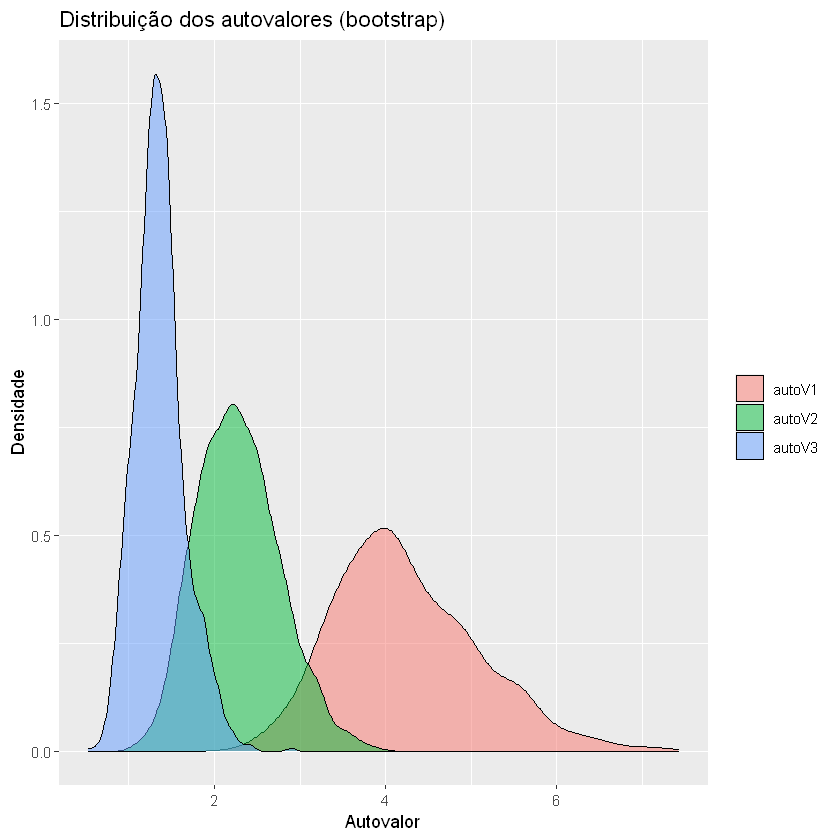

In [17]:
autoBootGrafico = reshape2::melt ( data = autoBootDf , id.vars = NULL )

autoBootGrafico %>% ggplot ( aes ( x = value , fill = variable) ) + 
geom_density ( alpha = 0.5 ) +
labs ( x = "Autovalor" , y = "Densidade" , title = "Distribuição dos autovalores (bootstrap)" , fill = NULL)

In [18]:
printLC = function ( num , vetor ){
    
    quantis = quantile ( vetor , c ( .025 , .975 ) )
    print ( paste0 ( "O intervalo bootstrap para o autovetor " , 
                    num ,
                   " é dado por [" ,
                    round ( quantis[[1]] , 2 ) ,
                    ";" ,
                    round ( quantis[[2]] , 2 ) ,
                    "]"
                   ) )
    
}

for ( i in 1:3 ){
    
    printLC ( i , autoBootDf[ , paste0 ( "autoV" , i ) ] )
    
}



[1] "O intervalo bootstrap para o autovetor 1 é dado por [2.87;6.11]"
[1] "O intervalo bootstrap para o autovetor 2 é dado por [1.47;3.26]"
[1] "O intervalo bootstrap para o autovetor 3 é dado por [0.87;2.02]"


b) A Função Discriminante de Fisher é um classificador ótimo em muitas situações práticas. É obtida a partir da decomposição espectral de W-1B, com W e B matrizes de covariância entre e dentro de grupo, respectivamente. Os autovalores desta decomposição espectral podem ser usados no seguinte teste de significância do poder discriminante das funções de Fisher:
<center>
  $(n-1-\frac{p+G}{2})ln(1+\lambda_{j})\sim\chi^2_{p+G-2j}$
</center>
Em que n é o tamanho amostral (n=17, no caso dos dados dos caracóis), p é o número de variáveis (p=9), G é o número de grupos (G=6), $\lambda_j$ é o j-ésimo autovalor (j=,1,2,...,min(n,p,G-1)) e $\chi^2$ é a distribuição Qui-Quadrado com o correspondente número de graus de liberdade. A significância desta estatística para um conjunto de dados amostrais é uma indicação de que a discriminação não é aleatória (esporádica). Para os dados dos caracóis obtenha as duas primeiras funções discriminantes e represente as 17 colônias. Os 6 habitats podem ser bem preditos? Com base na estatística Qui-Quadrado o que é possível concluir sobre o poder discriminante das funções de Fisher neste caso? Construa também os correspondentes Testes de Aleatorização.

In [19]:
# Modelo Habitat ~ 9 covariáveis (excluindo idRow e colony)
fit.lda <- MASS::lda( Habitat ~ YellowUB + YellowMB + YellowFB + YellowOB + PinkUB + PinkMB + PinkFB + PinkOB + BrownUB ,prior= rep ( 1 , 6 ) / 6 , data = dadosPad  )
fit.lda

Call:
lda(Habitat ~ YellowUB + YellowMB + YellowFB + YellowOB + PinkUB + 
    PinkMB + PinkFB + PinkOB + BrownUB, data = dadosPad, prior = rep(1, 
    6)/6)

Prior probabilities of groups:
            Downland beech Downside long course grass 
                 0.1666667                  0.1666667 
       Downside short turf                  Hedgerows 
                 0.1666667                  0.1666667 
     Mixed deciduous woods                    Oakwood 
                 0.1666667                  0.1666667 

Group means:
                             YellowUB    YellowMB    YellowFB   YellowOB
Downland beech              0.5162747  1.54804814 -0.85730304 -0.9711100
Downside long course grass -0.7647133  0.78221480  1.13934872  0.9321508
Downside short turf         2.8753220  1.04329435 -0.85730304 -0.4552078
Hedgerows                   0.2816383 -0.24469809  0.78431029  0.6184265
Mixed deciduous woods      -0.3106601 -0.88521324 -0.08817029  0.1471429
Oakwood                    -0

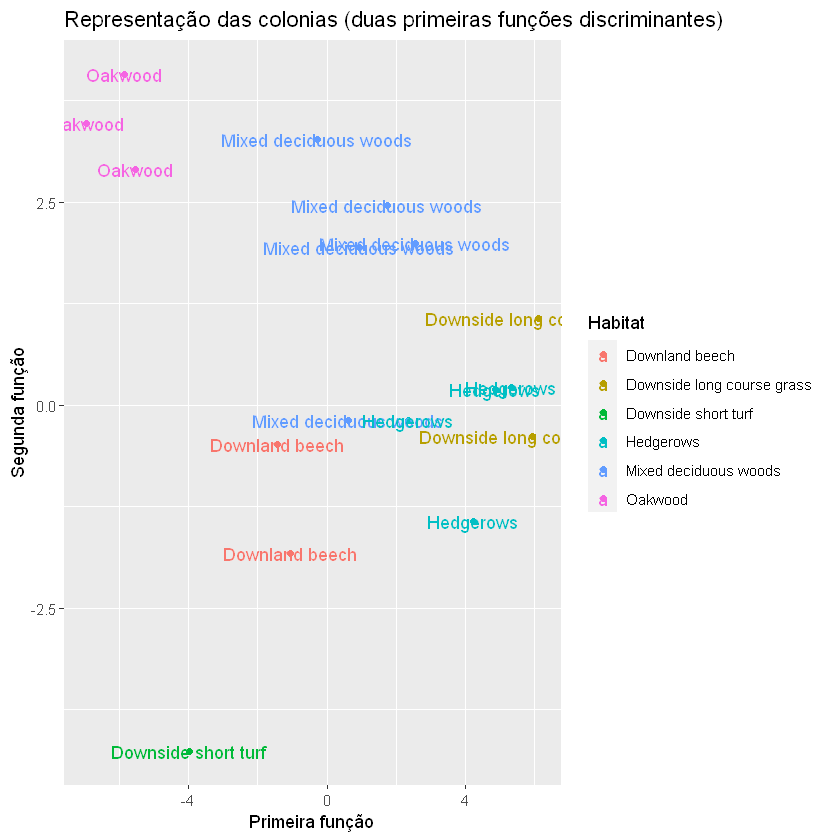

In [20]:
fit.ldavalues <- predict(fit.lda, dadosPad [,c( 'YellowUB' , 'YellowMB' , 'YellowFB' , 'YellowOB' , 'PinkUB' , 'PinkMB' , 'PinkFB' , 'PinkOB' , 'BrownUB' )] )
scores = fit.ldavalues$x %>% as.data.frame () %>% mutate ( idRow = 1:17 )
scoresMerge = merge ( scores , dadosPad[ , c ( "idRow" , "Habitat" )] , by = 'idRow' )
scoresMerge %>% ggplot ( aes ( x = LD1 , y = LD2 , label = Habitat , colour = Habitat) ) + 
geom_point ( ) +
geom_text ( ) +
labs ( title = "Representação das colonias (duas primeiras funções discriminantes)" , x = "Primeira função" , y = "Segunda função" )

In [21]:
ct <- table( dadosPad[ , "Habitat" ] ,fit.ldavalues$class)
print ( diag ( prop.table ( ct , 1 ) ) )

            Downland beech Downside long course grass 
                         1                          1 
       Downside short turf                  Hedgerows 
                         1                          1 
     Mixed deciduous woods                    Oakwood 
                         1                          1 


Descritivamente percebe-se que os habitats "Oakwood", "Downside short turf" e "Downland beech" se discriminam bem, apesar dos demais estarem aglomerados.

In [22]:
table(dadosPad$Habitat , predict(fit.lda, dadosPad [,c(-1 , -12 , -2)],method="plug-in")$class)

                            
                             Downland beech Downside long course grass
  Downland beech                          2                          0
  Downside long course grass              0                          2
  Downside short turf                     0                          0
  Hedgerows                               0                          0
  Mixed deciduous woods                   0                          0
  Oakwood                                 0                          0
                            
                             Downside short turf Hedgerows
  Downland beech                               0         0
  Downside long course grass                   0         0
  Downside short turf                          1         0
  Hedgerows                                    0         4
  Mixed deciduous woods                        0         0
  Oakwood                                      0         0
                            
   

In [23]:
fit.lda$svd

[1] 7.8995975 4.4825582 2.7683187 1.9198208 0.5320327

In [24]:
# estatistica qui-quadrado
n = 17
p = 9
G = 6

valores = ( n - 1 - ( p + G ) / 2 ) * log ( 1 + fit.lda$svd )
for ( i in 1:5 ){
    
    print ( pchisq ( valores [ i ] , df = ( p + G - 2 * i ) , lower.tail = F ) )
    
}

[1] 0.136677
[1] 0.2084054
[1] 0.2572414
[1] 0.2449991
[1] 0.6044046


Com base na estatística Qui-Quadrado, podemos concluir que não há evidências de que as funções de Fisher discriminem os Habitats.

In [25]:
# Limites de confianca
numeroSimulacoes = 1e3
autoBoot = c ( )
i = 1
set.seed ( 9297791 )

while ( i <= numeroSimulacoes ){
    
    marcacaoAleat = dadosPad [ sample ( rownames ( dadosPad ) ) , "Habitat" ]
    dfBoot2b = cbind(dadosPad[ , 3:11 ] , marcacaoAleat )
    fit.ldaBoot = MASS::lda( marcacaoAleat ~ YellowUB + YellowMB + YellowFB + YellowOB + PinkUB + PinkMB + PinkFB + PinkOB + BrownUB ,prior= rep ( 1 , 6 ) / 6 , data = dfBoot2b  )
    valoresBoot = ( n - 1 - ( p + G ) / 2 ) * log ( 1 + fit.ldaBoot$svd )
    autoBoot = rbind ( autoBoot , valoresBoot )
                
    i = i + 1
    
    
}

In [26]:
dfTesteAleat = autoBoot %>% as.data.frame ( )
colnames ( dfTesteAleat ) = c ( "lambda1" , "lambda2" , "lambda3" , "lambda4" , "lambda5" )
dfTesteAleat %>% head ( 5 )

,lambda1,lambda2,lambda3,lambda4,lambda5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
valoresBoot,15.09412,11.17187,10.427961,5.547993,4.442833
valoresBoot.1,17.02563,10.01688,8.072498,6.149771,3.956671
valoresBoot.2,15.72736,12.08885,9.450310,9.185966,7.366587
valoresBoot.3,22.46251,15.49021,10.028010,6.887360,4.878792
valoresBoot.4,19.44380,14.44868,10.388040,8.436970,6.233538


[1] "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda1 é dado por:0.428"


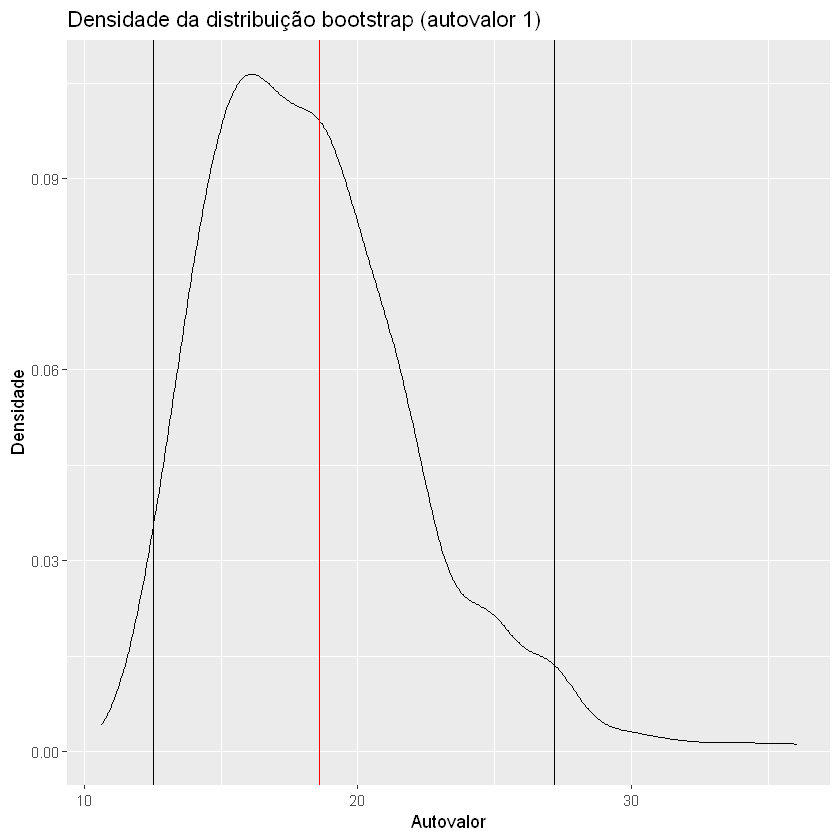

[1] "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda2 é dado por:0.156"


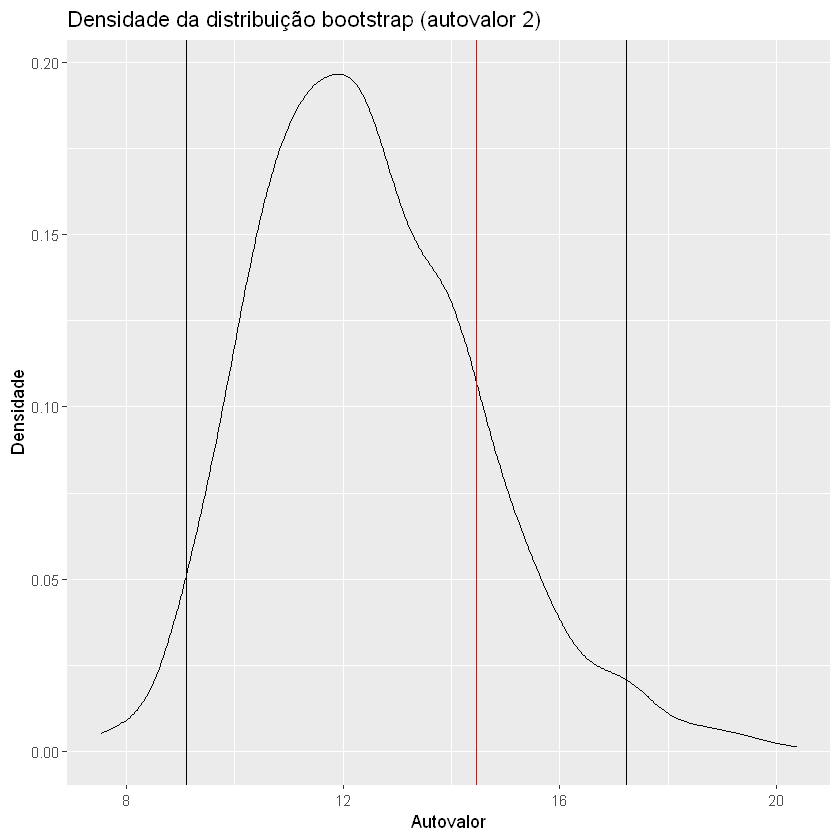

[1] "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda3 é dado por:0.079"


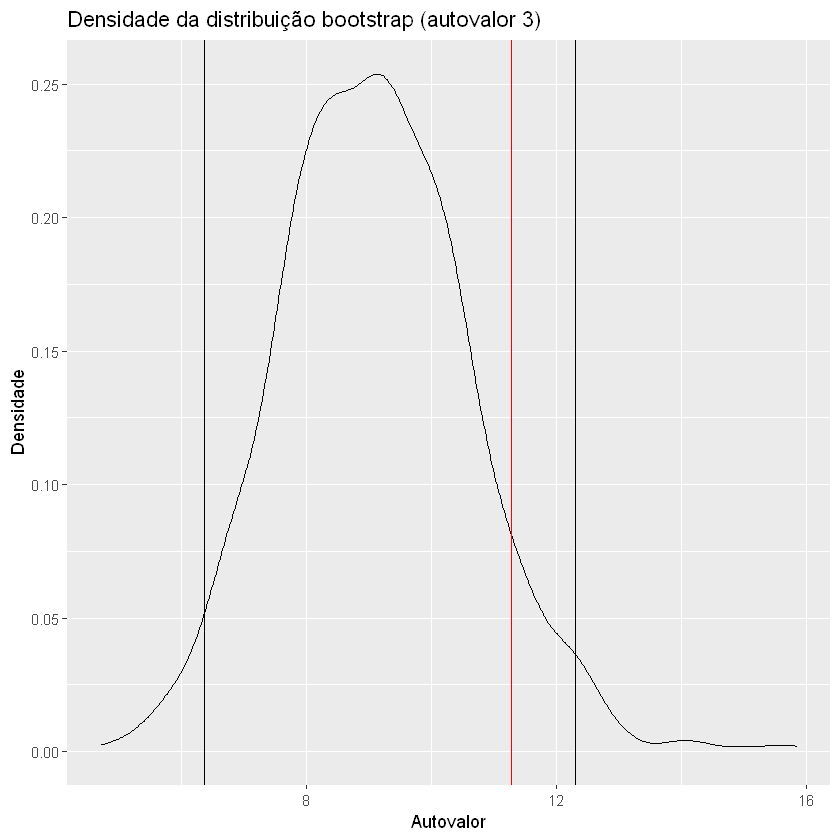

[1] "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda4 é dado por:0.019"


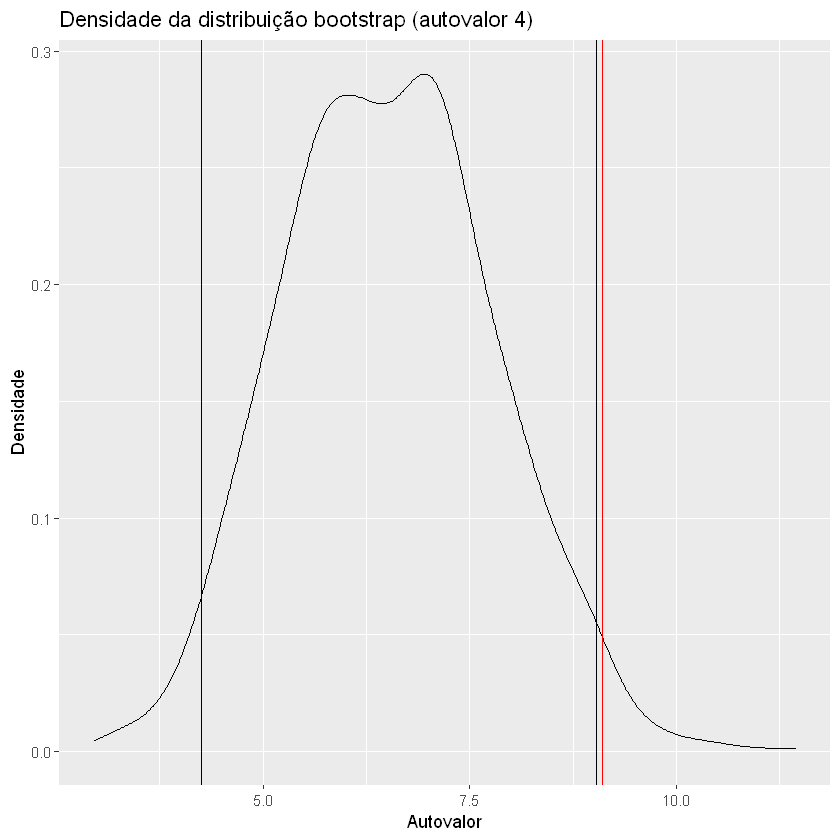

[1] "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda5 é dado por:0.666"


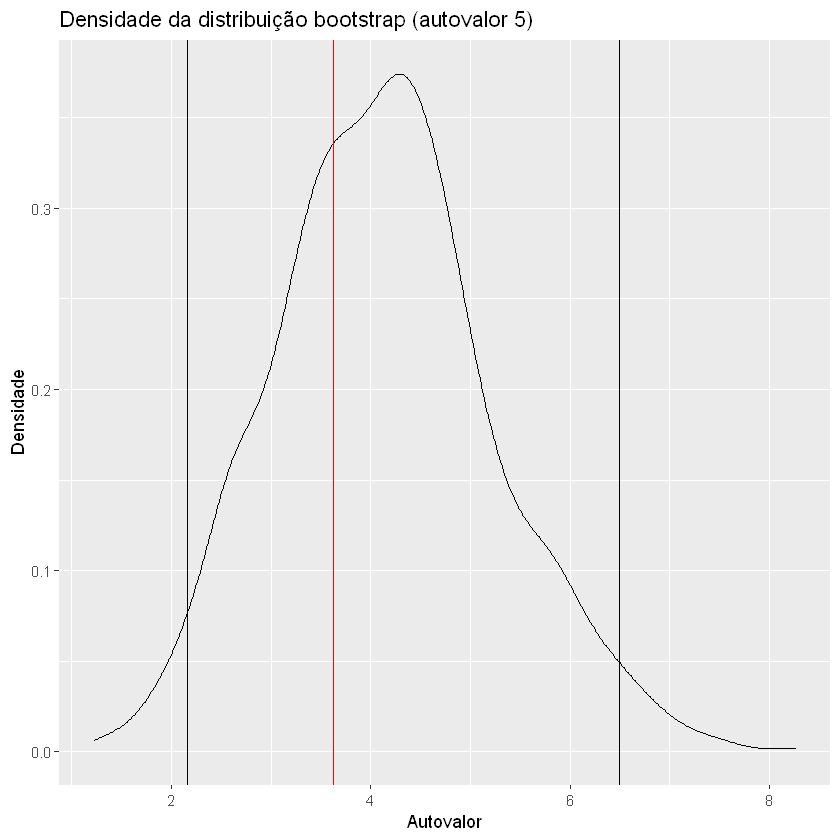

In [27]:
plotDfAleat = reshape2::melt ( dfTesteAleat , id.vars = NULL )

plotaValores = function ( df , valor , i ){
        
        dfFilt = df[ df$variable == paste0( "lambda" , i ) , ] %>% 
        mutate ( maiorLambda = ifelse ( value > valor , 1 , 0 ) )
    
        quantiles = quantile(dfFilt$value , c(0.025 , 0.975))
        
        plot = dfFilt %>%  
        ggplot ( aes ( x = value ) ) + 
        geom_density ( ) +
        geom_vline ( xintercept = quantiles[[1]] ) +
        geom_vline ( xintercept = quantiles[[2]] ) +
        geom_vline ( xintercept = valor , col = 'red' ) +
        labs ( x = "Autovalor" , y = "Densidade" , title = paste0( "Densidade da distribuição bootstrap (autovalor " , i ,")" ) )
        print ( plot ) 
    
        print ( paste0 ( "Temos que, no teste de aleatorização, o nível descritivo do teste para lambda" ,
                        i ,
                        " é dado por:" ,
                        mean ( dfFilt$maiorLambda )
                       ) )
            
}

for ( i in 1:5 ){
    
    plotaValores ( plotDfAleat , valores[ i ] , i )
    
}

A partir do teste de aleatorização, conclui-se que apenas a função associada ao quarto autovalor não discrimina ao acaso (enquanto não há evidências para a mesma conclusão em relação aos demais autovalores).

3. Agora, considere os dados dos caracóis com o objetivo de calcular a correlação canônica entre os dois conjuntos de variáveis definidas para conchas yellow e pink (com p=q=4). Calcule os coeficientes de correlação canônicos para estes dados. Quais variáveis mais contribuíram para a correlação? Obtenha também, para cada coeficiente, intervalos bootstrap de 95% de confiança. Esses intervalos incluem o zero?

In [28]:
yellow = dadosPad [,c( 'YellowUB' , 'YellowMB' , 'YellowFB' , 'YellowOB')]
pink = dadosPad [,c( 'PinkUB' , 'PinkMB' , 'PinkFB' , 'PinkOB')]
corrCan = cancor( yellow , pink )

In [29]:
print ( paste0 ( "Coeficiente " , 1:4 , " de correlação canônica: " , corrCan$cor ) )
print ( paste0 ( "Os primeiros " , length ( which ( corrCan$cor >= mean (corrCan$cor) ) ) , " coeficientes são maiores do que a média" ) )

[1] "Coeficiente 1 de correlação canônica: 0.833606309653776"
[2] "Coeficiente 2 de correlação canônica: 0.712930376796804"
[3] "Coeficiente 3 de correlação canônica: 0.501893762739201"
[4] "Coeficiente 4 de correlação canônica: 0.10706845838606" 
[1] "Os primeiros 2 coeficientes são maiores do que a média"


In [30]:
corrCan$xcoef
corrCan$ycoef

YellowUB,-0.15899658,-0.06986814,0.07852641,0.19392506
YellowMB,0.05463863,-0.19889762,0.04340587,-0.17400158
YellowFB,-0.12171530,-0.08043214,-0.25064969,0.08312324
YellowOB,-0.11495999,0.07605827,0.15570355,-0.22303777


PinkUB,0.11151305,0.09159543,0.12310150,0.2093691
PinkMB,0.21959427,-0.01686966,-0.09384067,-0.1634551
PinkFB,0.15202943,0.04679939,-0.32529201,0.1377263
PinkOB,-0.07078696,0.22954460,0.23672285,-0.1299163


Variáveis importantes para a correlação:
* Primeira combinação - todas, menos YellowMB e PinkOB;
* Segunda combinação - YellowMB e PinkOB;
* Terceira combinação - YellowFB , YellowOB , PinkFB e PinkOB
* Quarta combinação - todas, menos YellowFB

Agora, os intervalos bootstrap:

In [31]:
numeroSimulacoes = 1e3
corBoot = c ( )
i = 1
set.seed ( 9297791 )

while ( i <= numeroSimulacoes ){
    
    datBoot = dadosPad [ sample ( rownames ( dadosPad ) , replace = T ) , ]
    yellowBoot = datBoot [,c( 'YellowUB' , 'YellowMB' , 'YellowFB' , 'YellowOB')]
    pinkBoot = datBoot [,c( 'PinkUB' , 'PinkMB' , 'PinkFB' , 'PinkOB')]
    corrCanBoot = cancor( yellowBoot , pinkBoot )
    calcCorrBoot = corrCanBoot$cor
    corBoot = rbind ( corBoot , calcCorrBoot )
                
    i = i + 1
    
    
}

In [32]:
dfcorBoot = corBoot %>% as.data.frame ( )
colnames ( dfcorBoot ) = c ( "cor1" , "cor2" , "cor3" , "cor4" )
dfcorBoot %>% head ( 5 )

,cor1,cor2,cor3,cor4
,<dbl>,<dbl>,<dbl>,<dbl>
calcCorrBoot,0.8947774,0.8009356,0.4293503,0.1752355
calcCorrBoot.1,0.9975877,0.9541043,0.8602290,0.3387262
calcCorrBoot.2,0.8192977,0.6632582,0.5644352,0.4623929
calcCorrBoot.3,0.9919917,0.8022785,0.2639366,0.1820283
calcCorrBoot.4,0.9770748,0.9335160,0.5179401,0.1703673


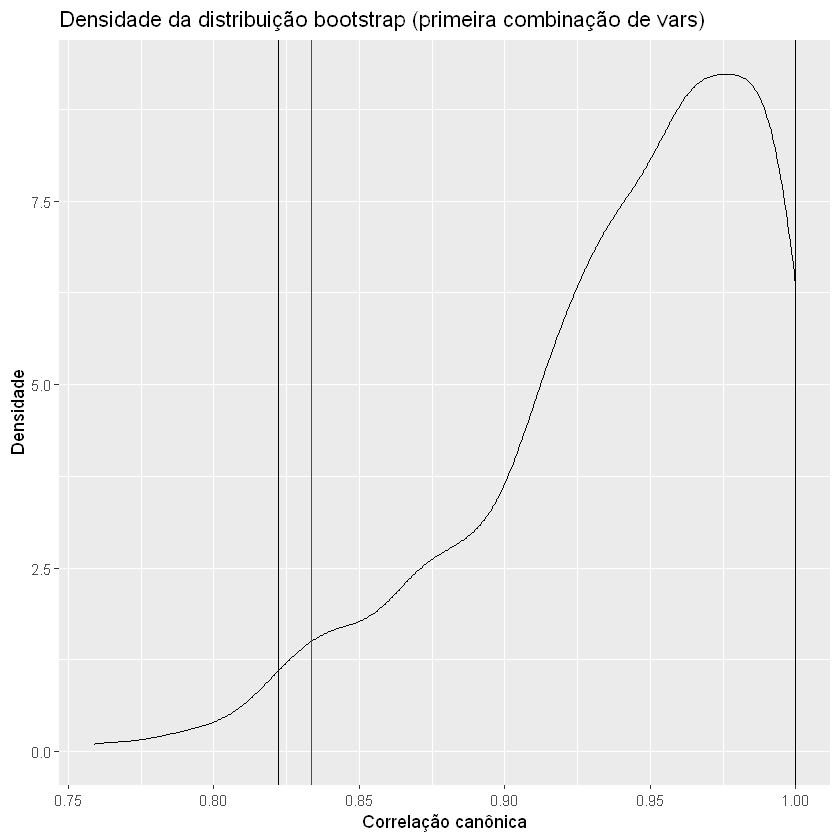

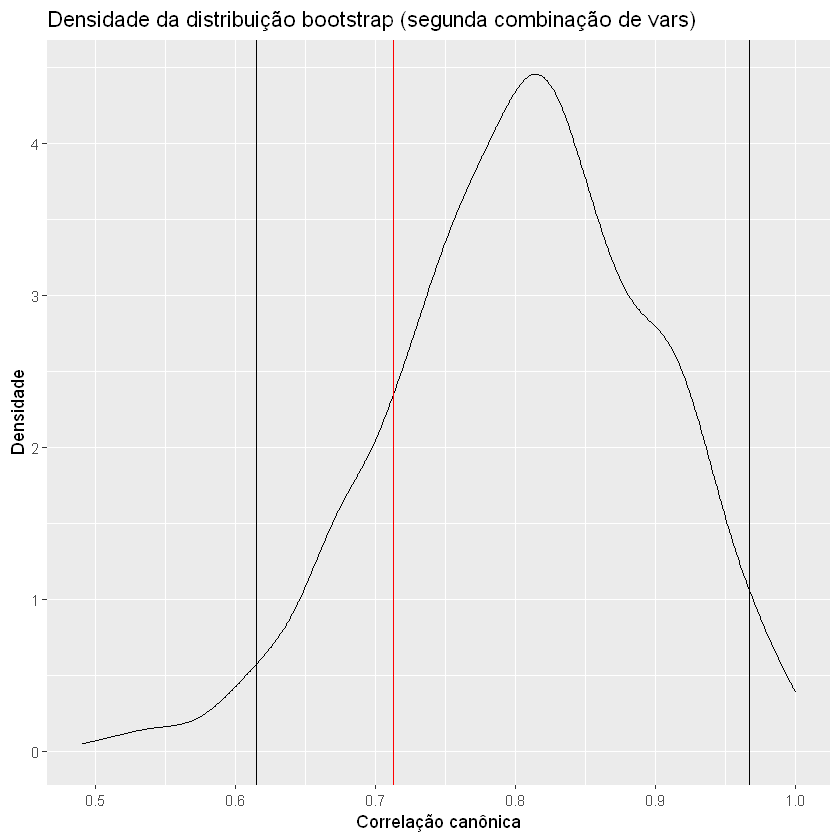

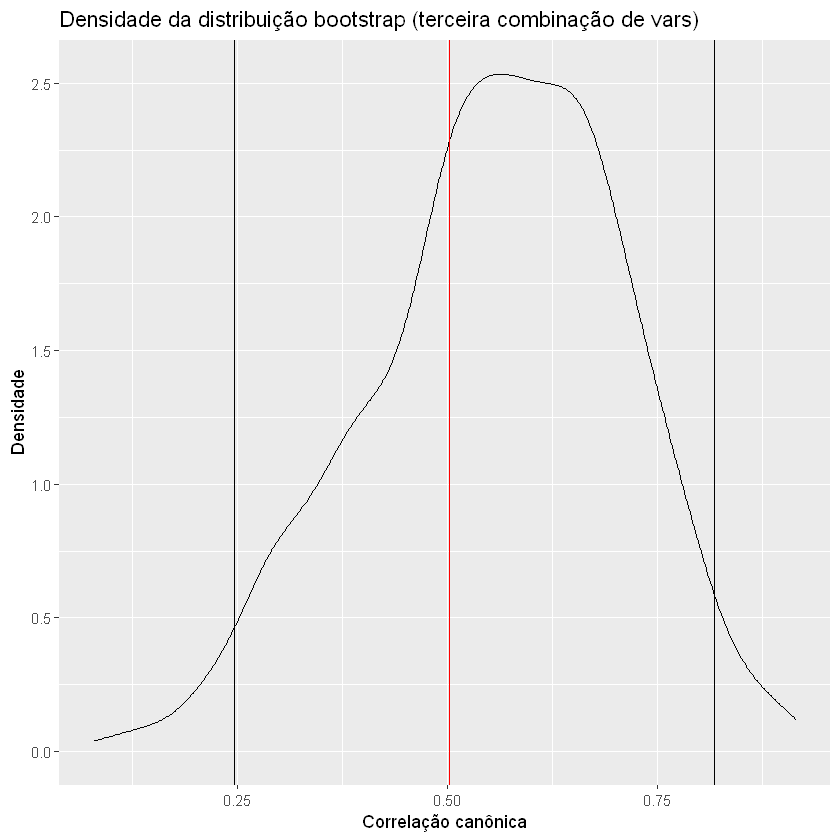

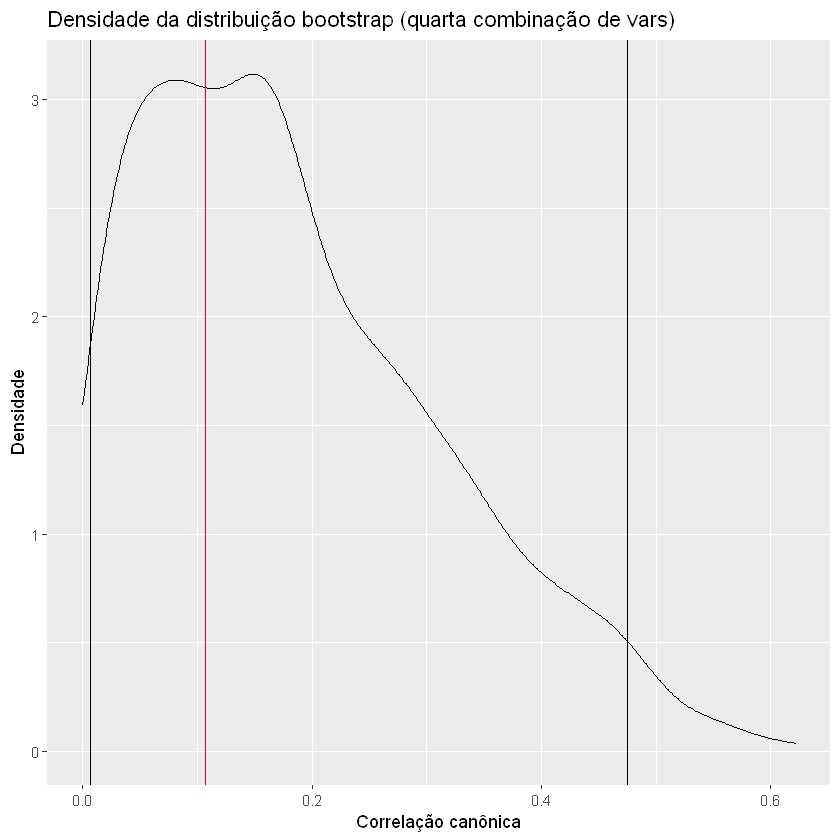

In [33]:
plotDfCor = reshape2::melt ( dfcorBoot , id.vars = NULL )
plotaValores = function ( df , valor , i ){
        
        dfFilt = df[ df$variable == paste0( "cor" , i ) , ]
        quantiles = quantile(dfFilt$value , c(0.025 , 0.975))
        
        if ( i == 1){
            titulo = "primeira"
        } else if ( i == 2 ){
            titulo = "segunda"
        } else if( i == 3 ){
            titulo = "terceira"
        } else { titulo = "quarta" }
        
        plot = dfFilt %>%  
        ggplot ( aes ( x = value ) ) + 
        geom_density ( ) +
        geom_vline ( xintercept = quantiles[[1]] ) +
        geom_vline ( xintercept = quantiles[[2]] ) +
        geom_vline ( xintercept = valor , col = 'red' ) +
        labs ( x = "Correlação canônica" , y = "Densidade" , title = paste0( "Densidade da distribuição bootstrap (" , titulo , " combinação de vars)" ) )
        print ( plot ) 
                
}

for ( i in 1:4 ){
    
    plotaValores ( plotDfCor , corrCan$cor[ i ] , i )
    
}

In [34]:
printLC = function ( num , vetor ){
    
    quantis = quantile ( vetor , c ( .025 , .975 ) )
    if ( i == 1){
        titulo = "primeira"
    } else if ( i == 2 ){
        titulo = "segunda"
    } else if( i == 3 ){
        titulo = "terceira"
    } else { titulo = "quarta" }

    print ( paste0 ( "O intervalo bootstrap para a " , 
                    titulo ,
                   " combinação é dado por [" ,
                    round ( quantis[[1]] , 2 ) ,
                    ";" ,
                    round ( quantis[[2]] , 2 ) ,
                    "]"
                   ) )
    
}

for ( i in 1:4 ){
    
    printLC ( i , dfcorBoot[ , paste0 ( "cor" , i ) ] )
    
}


[1] "O intervalo bootstrap para a primeira combinação é dado por [0.82;1]"
[1] "O intervalo bootstrap para a segunda combinação é dado por [0.61;0.97]"
[1] "O intervalo bootstrap para a terceira combinação é dado por [0.25;0.82]"
[1] "O intervalo bootstrap para a quarta combinação é dado por [0.01;0.47]"


Como pode-se observar, para nenhuma das combinações lineares o intervalo inclui o 0 (a 95% de confiança).